<a href="https://colab.research.google.com/github/AnkitaSinha98/Machine-Learning/blob/main/kmode%26kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Techniques (CSE6024) Cycle Sheet-4
## ANKITA SINHA 20MCI0003

Team Members: 20MCI0014, and 20MCI0010
Libraries used: numpy, pandas, matplotlib.pyplot, randon, warning, scipy, and sklearn.

Datasets used: Bankmarket.csv and make_blobs
 
Experiments: K Mode and K means Clustering

# K modes clustering

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas
import random 
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt  

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
data = pandas.read_csv("gdrive/My Drive/Dataset/bankmarketing.csv")

label =data.iloc[:,-1]

data_numeric = data.loc[:,data.dtypes!=np.object]
print(data_numeric.head())

data_cat = data.loc[:,data.dtypes==np.object]
print(data_cat.head())

   age  duration  campaign  ...  cons.conf.idx  euribor3m  nr.employed
0   56       261         1  ...          -36.4      4.857       5191.0
1   57       149         1  ...          -36.4      4.857       5191.0
2   37       226         1  ...          -36.4      4.857       5191.0
3   40       151         1  ...          -36.4      4.857       5191.0
4   56       307         1  ...          -36.4      4.857       5191.0

[5 rows x 10 columns]
         job  marital    education  default  ... month day_of_week     poutcome   y
0  housemaid  married     basic.4y       no  ...   may         mon  nonexistent  no
1   services  married  high.school  unknown  ...   may         mon  nonexistent  no
2   services  married  high.school       no  ...   may         mon  nonexistent  no
3     admin.  married     basic.6y       no  ...   may         mon  nonexistent  no
4   services  married  high.school       no  ...   may         mon  nonexistent  no

[5 rows x 11 columns]


In [4]:
def chi_square_test(feature1, feature2):
  result = []
  result.append(feature1)

  contingency_table = pandas.crosstab(data_cat[feature1], data_cat[feature2])
  observed_values = contingency_table.values
  chi_square_result = stats.chi2_contingency(contingency_table)
  expected_values = chi_square_result[3]

  ## calculate degree of freedom ( more the degree more chances of getting good results)

  no_rows = len(contingency_table.iloc[0:2,0])
  no_columns = len(contingency_table.iloc[0,0:2])

  degree_freedom = (no_rows-1) / (no_columns-1)
  result.append(degree_freedom)

  ## Significance level (Generally used for the test)
  alpha=0.05
  
  chi_square = sum([(o-e)**2./e for o,e in zip(observed_values, expected_values)])
  chi_square_statistic = chi_square[0] + chi_square[1]
  result.append(chi_square_statistic)

  critical_value = stats.chi2.ppf(q = 1-alpha, df=degree_freedom)
  result.append(critical_value)

  p_value = 1 - stats.chi2.cdf(x = chi_square_statistic, df = degree_freedom)
  result.append(p_value) 

  ## Check for Null hypothesis using p_value and chi_square statistics

  if chi_square_statistic >= critical_value or p_value <= alpha:
    result.append('True')
    return result
  else:
    result.append('False')
    return result

In [5]:
corr_cat = []
for i in data_cat.columns.tolist()[:-1]:
  corr_cat.append(chi_square_test(i,'y'))

cat_corr = pandas.DataFrame(corr_cat, columns=['Feature' , 'DOF', 'Chi_Sq-Stats', 'critical_val', 'p_value', 'Correlated'])

In [6]:
cat_corr

Feature  DOF  Chi_Sq-Stats  critical_val       p_value Correlated
0          job  1.0    961.242440      3.841459  0.000000e+00       True
1      marital  1.0    122.655152      3.841459  0.000000e+00       True
2    education  1.0    193.105905      3.841459  0.000000e+00       True
3      default  1.0    406.577515      3.841459  0.000000e+00       True
4      housing  1.0      5.684496      3.841459  1.711546e-02       True
5         loan  1.0      1.094028      3.841459  2.955806e-01      False
6      contact  1.0    863.269081      3.841459  0.000000e+00       True
7        month  1.0   3101.149351      3.841459  0.000000e+00       True
8  day_of_week  1.0     26.144939      3.841459  3.167261e-07       True
9     poutcome  1.0   4230.523798      3.841459  0.000000e+00       True

In [7]:
data['y'] = data['y'].map({'yes':True ,'no':False})
# replace_map = {'y': {'yes': 1, 'no': 0}}
# data.replace(replace_map, inplace=True)
data['age_bin'] = pandas.cut(data['age'], [0, 20, 30, 40, 50, 60, 70, 80, 90, 100],labels=['0-20', '20-30', '30-40', '40-50','50-60','60-70','70-80', '80-90','90-100'])

data  = data.drop('age',axis = 1)

features = data[['age_bin','job', 'marital', 'education',\
              'default', 'housing','contact',\
              'month','day_of_week','poutcome','y']]

le = LabelEncoder()
features_encoded = features.apply(le.fit_transform)


label=data[['y']]


K MODE Clustering starts

In [9]:

def pickup_centroids(df,k):
    centroids_idx = np.random.choice(a = df.index.values, replace = False, size = k)
    centroid_a = df.loc[centroids_idx[0]].values
    centroid_b = df.loc[centroids_idx[1]].values
    return(centroid_a,centroid_b)

def distance_mismatch(a,b):
    return (a != b).sum()

def compute_distances_to_centroids(centroid_a,centroid_b,df):
    
    dic_distances = {}
    for idx,row in df.iterrows():
        candidat = row.values
        distance_to_a = distance_mismatch(candidat[:-1],centroid_a[:-1])
        distance_to_b = distance_mismatch(candidat[:-1],centroid_b[:-1])
        affectation = np.argmin([distance_to_a,distance_to_b])
        dic_distances[idx] = {"distance_to_a" : distance_to_a,
                              "distance_to_b" : distance_to_b,
                              "cluster" : affectation}
        
    return dic_distances


def extract_assigned_data(dic_distances,df):
    c1list = []
    c2list = []
    for k,v in dic_distances.items():
        if v["cluster"] == 0:
            c1list.append(df.loc[k].values)
        else:
            c2list.append(df.loc[k].values)

    if len(c1list)>0:
        a = np.vstack(c1list)
    else:
        a = np.array([])
        
    if len(c2list)>0:
        b = np.vstack(c2list)
    else:
        b = np.array([])
        
    return a,b


def compute_mode(array):
    return stats.mode(array)[0][0]


def compute_performance(dic_distances):
    
    distances_list = []
    for k,v in dic_distances.items():
        if v["cluster"] == 0:
            distances_list.append(v["distance_to_a"])
        else:
            distances_list.append(v["distance_to_b"])
    return (np.array(distances_list)).sum()


K Mode logic

In [10]:
%%timeit
def kmodes(df,k=2,threshold=1,iterations=5, verbose = True):
   
  dic_results = {}  
  centroid_a,centroid_b = pickup_centroids(df,k)

  for i in range(iterations):

    if verbose:
      print("iteration : ",i)

      dic_distances = compute_distances_to_centroids(centroid_a,centroid_b,df)
      array_a,array_b = extract_assigned_data(dic_distances,df)
      mycdt = len(array_a)==0 or len(array_b)==0

      if mycdt:
        continue

      futur_centroid_a = compute_mode(array_a)
      futur_centroid_b = compute_mode(array_b)

      print('iteration : ' + str(i) + ' - complete')

      d = distance_mismatch(futur_centroid_a,centroid_a) + distance_mismatch(futur_centroid_b,centroid_b)

      if verbose:
        print("distance between present and new centroids : ", d)

      if d<threshold:
        break
      
      centroid_a = futur_centroid_a
      centroid_b = futur_centroid_b
                 
  print("Total elements in cluster 1 " + str(len(array_a)))
  print("Total elements in cluster 2 " + str(len(array_b)))

  df_pred = df.copy()
  df_pred['pred_cluster'] = pandas.Series(np.random.randn(len(df)), index=df_pred.index)
  for idx,row in df_pred.iterrows():
    df_pred.iloc[idx,-1] = dic_distances[idx]['cluster']

  return df_pred

  
def main():

  df = kmodes(features, verbose = True)
  print(df.head())
  return df

kmodes_clsuter_df = main()
kmodes_clsuter_df['y'] = kmodes_clsuter_df['y'].astype('float16')

iteration :  0
iteration : 0 - complete
distance between present and new centroids :  3
iteration :  1
iteration : 1 - complete
distance between present and new centroids :  0
Total elements in cluster 1 25529
Total elements in cluster 2 15659
  age_bin        job  marital  ...     poutcome      y pred_cluster
0   50-60  housemaid  married  ...  nonexistent  False          0.0
1   50-60   services  married  ...  nonexistent  False          0.0
2   30-40   services  married  ...  nonexistent  False          0.0
3   30-40     admin.  married  ...  nonexistent  False          0.0
4   50-60   services  married  ...  nonexistent  False          0.0

[5 rows x 12 columns]
iteration :  0
iteration : 0 - complete
distance between present and new centroids :  13
iteration :  1
iteration : 1 - complete
distance between present and new centroids :  0
Total elements in cluster 1 28863
Total elements in cluster 2 12325
  age_bin        job  marital  ...     poutcome      y pred_cluster
0   50-60  h

# K Means Clustering

In [12]:
from sklearn.datasets import make_blobs
data = make_blobs(n_samples = 800, centers = 3, n_features = 2, cluster_std = 1.5, shuffle = True, random_state = 50)
data

(array([[-6.59434748, -2.4795557 ],
        [-1.44233247, 10.09901821],
        [-0.5009282 , -5.31356688],
        ...,
        [-7.4583852 , -2.91591304],
        [-1.41755412,  9.83551745],
        [-6.44088807, -1.65605727]]),
 array([1, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        2, 0, 2, 2, 2, 1, 0, 1, 0, 1, 2, 0, 2, 0, 1, 2, 0, 1, 2, 2, 2, 0,
        1, 0, 1, 0, 0, 1, 2, 1, 0, 0, 2, 2, 1, 0, 1, 0, 1, 1, 1, 2, 1, 2,
        0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 1, 0, 0, 1, 1, 0, 2,
        0, 0, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 2,
        2, 0, 2, 2, 1, 2, 2, 2, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 2, 0, 0, 2,
        0, 1, 1, 1, 2, 2, 2, 0, 1, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 1, 0, 1,
        2, 2, 0, 2, 2, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 2, 2, 0, 1, 1,
        2, 2, 1, 1, 1, 2, 0, 2, 0, 1, 1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0,
        0, 2, 0, 1, 1, 1, 2, 2, 1, 0, 1, 0, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1,
        0, 2, 1, 2, 1, 2, 2, 

In [13]:
pts = data[0]
pts

array([[-6.59434748, -2.4795557 ],
       [-1.44233247, 10.09901821],
       [-0.5009282 , -5.31356688],
       ...,
       [-7.4583852 , -2.91591304],
       [-1.41755412,  9.83551745],
       [-6.44088807, -1.65605727]])

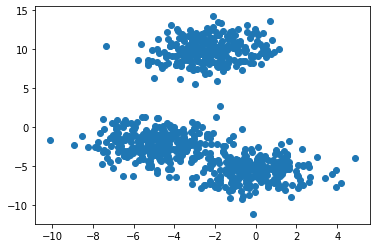

In [14]:
plt.scatter(data[0][:,0], data[0][:,1])

In [16]:
df = pandas.DataFrame({'x': data[0][:,0],'y': data[0][:,1]})

In [17]:
df

x          y
0   -6.594347  -2.479556
1   -1.442332  10.099018
2   -0.500928  -5.313567
3   -3.654380   9.459896
4   -0.444785  -6.298762
..        ...        ...
795 -6.336402  -3.117507
796  1.178076  -7.697622
797 -7.458385  -2.915913
798 -1.417554   9.835517
799 -6.440888  -1.656057

[800 rows x 2 columns]

In [18]:
df.describe()

x           y
count  800.000000  800.000000
mean    -2.439103    0.746014
std      2.456023    6.787830
min    -10.084702  -11.153173
25%     -4.301530   -4.726922
50%     -2.272177   -1.993031
75%     -0.636460    8.626402
max      4.863146   14.230083

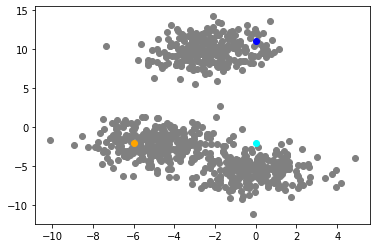

In [19]:
np.random.seed(400)
n_clusters = 3
centroids = {
    i+1 : [int(data[0][np.random.randint(0,799),0]), int(data[0][np.random.randint(0,799),1])]
    for i in range(n_clusters)
}

figure = plt.figure(figsize=(6,4))
plt.scatter(df['x'], df['y'], color = 'gray')
colormap = {1 : 'blue', 2 : 'orange', 3 : 'cyan'}
for i in centroids.keys():
  plt.scatter(*centroids[i], color = colormap[i])
plt.show()

In [20]:
centroids

{1: [0, 11], 2: [-6, -2], 3: [0, -2]}

In [21]:
def cluster_assignment(X, centroids, k):
  clusters = {}
  # Set the range for value of k(number of cluster centroids)
  for i in range(k):
    clusters[i] = []
  # Setting the plot points using dataframe (X) and the norm 
  for i in X:
    # Set up list of euclidian distance and iterate 
    euclidian_dist = []
    for j in range(k):
      euclidian_dist.append(np.linalg.norm(i - centroids[j]))
    # Append the cluster of data (index of minimum euclidian distance) to the dictionary
    clusters[euclidian_dist.index(min(euclidian_dist))].append(i)
  return clusters

In [22]:
def move_centroid(centroid, clusters, k):
  for i in range(k):
    # Finds the average of the cluster at the particular index
    centroids[i] = np.average(clusters[i], axis=0)
  return centroids

In [23]:
def view_clusters(centroids, clusters, k):
  colors = ['blue' ,'orange', 'cyan']
  plt.figure(figsize = (6, 4)) 
  for i in range(k):
    for cluster in clusters[i]:
        plt.scatter(cluster[0], cluster[1], c=colors[i % k], alpha=0.6)          
    plt.scatter(centroids[i][0], centroids[i][1], c='gray', s=200)

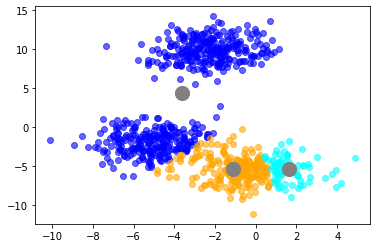

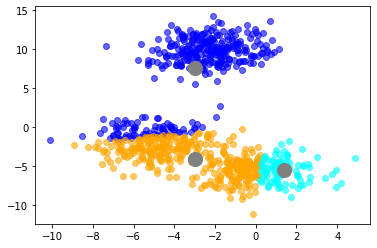

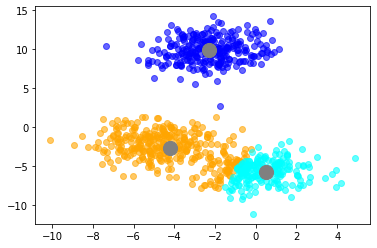

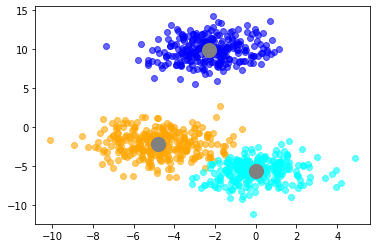

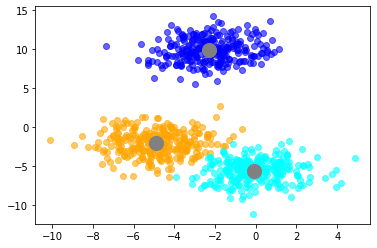

In [24]:
X = np.array(df[['x', 'y']])
centroids = {}
iter = 5
for i in range(n_clusters):
  centroids[i] = X[i*200]
for i in range(iter):        
  clusters = cluster_assignment(X, centroids, n_clusters)
  centroids = move_centroid(centroids, clusters, n_clusters)
  view_clusters(centroids, clusters, n_clusters)